In [19]:
import datetime
import netCDF4
import xarray as xr
import matplotlib as mpl
import cdsapi
import numpy as np
import warnings
import regionmask
import matplotlib.pyplot as plt
import pandas as pd
warnings.filterwarnings('ignore')
plt.style.use('default')
import cftime
import os
import seaborn as sns
import cartopy
import cartopy.feature as cpf
from global_land_mask import globe
import CMIP6_light_map
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry import box, mapping
import geopandas as gpd
import rioxarray
from matplotlib import cm
import cartopy.feature as cpf
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

In [20]:
def convert_to_180(ds):
    return ds.assign_coords(lon=(((ds.lon + 180) % 360) - 180)).sortby('lon')

In [21]:
def get_era5(era_datafile, start_time, end_time):
    era = netCDF4.Dataset(era_datafile)
    units = 'hours since 1900-01-01 00:00:00.0'
    time_gregorian = cftime.num2date(era.variables["time"], units, 'gregorian')
    units_to_wm2 =1./3600.

    times=[]
    for t in time_gregorian:
        obj = datetime.datetime(year=t.year, month=t.month, day=t.month, hour=t.hour)
        times.append(obj)
    times = pd.to_datetime(times,dayfirst=False)

    era = xr.open_dataset(era_datafile,
                          mask_and_scale=True)*units_to_wm2

    era = era.assign_coords({"time":times,"latitude":era.latitude,"longitude":era.longitude})
    return era.rename({"latitude":"lat", "longitude":"lon"}).sel(time=slice(start_time,end_time))

def get_mean_era5(era_datafile, start_time, end_time):
    era = netCDF4.Dataset(era_datafile)

    units = 'hours since 1900-01-01 00:00:00.0'
    time_gregorian = cftime.num2date(era.variables["time"], units, 'gregorian')
    units_to_wm2 =1.

    times=[]
    for t in time_gregorian:
        obj = datetime.datetime(year=t.year, month=t.month, day=t.month, hour=t.hour)
        times.append(obj)
    times = pd.to_datetime(times,dayfirst=False)

    era = xr.open_dataset(era_datafile,
                          mask_and_scale=True)*units_to_wm2

    era = era.assign_coords({"time":times,"latitude":era.latitude,"longitude":era.longitude})
    return era.rename({"latitude":"lat", "longitude":"lon"}).sel(time=slice(start_time,end_time))

def get_area_averaged_ds(fname,scenario,model,min_lat,max_lat,min_lon,max_lon,var_name,LME):

    with xr.open_dataset(fname) as ds:

        ds=convert_to_180(ds)
        ds=ds.sel(time=slice(start_time,end_time)).sel(lat=slice(min_lat,max_lat), lon=slice(min_lon,max_lon))
        lon_c,lat_c=np.meshgrid(ds.lon.values,ds.lat.values)
        is_in_ocean_c = globe.is_ocean(lat_c,lon_c)
        ds.coords['mask'] = (('lat', 'lon'), is_in_ocean_c)

        ds = ds[var_name].where(ds.mask==1).fillna(0)
        ds = get_data_within_LME(ds, var_name, LME, create_map=False)

        ds=ds.sel(time=slice("1979-01-01","2021-01-01")).mean({"lat","lon"})
        df = ds.to_dataframe().dropna()
        df = df.reset_index()
        df["scenario"]=scenario
        df["model"]=model

        return df

In [22]:
def get_LME_records():
    lme_file='../oceanography/Shapefiles/LME66/LMEs66.shp'
    return gpd.read_file(lme_file)

def get_LME_records_plot():
    lme_file='../oceanography/Shapefiles/LME66_180/LME66_180.shp'
    return gpd.read_file(lme_file)

def create_colors(N):
    color=iter(cm.tab20b(np.linspace(0,1,N)))
    return [next(color) for c in range(N)]

def create_map(df, title, var_name, period, anomalies=False, details=False):
    if details is True:
        lonmin=-165
        lonmax=-143.5
        latmin=53.5
        latmax=65.0
        res="10m"
    else:
        lonmin=-252
        lonmax=-100.5
        latmin=20
        latmax=80
        res="50m"
    ax = plt.figure(figsize=(16,10)).gca(projection=cartopy.crs.PlateCarree(central_longitude=-180))

    ax.coastlines(resolution=res, linewidth=0.6, color="black", alpha=0.8, zorder=4)
    ax.add_feature(cpf.BORDERS, linestyle=':',alpha=0.4)
    ax.add_feature(cpf.LAND, color="lightgrey")
    ax.set_extent([lonmin, lonmax, latmin, latmax])

    xticks = np.linspace(lonmin, lonmax, 5)
    yticks = np.linspace(latmin, latmax, 5)

    ax.set_xticks(xticks, crs=cartopy.crs.PlateCarree())
    ax.set_yticks(yticks, crs=cartopy.crs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)

    #if var_name in ["par"]:
    clb_label='PAR ($W/m^{2}$)'
    cs=ax.contourf(df["lon"], df["lat"], df[var_name], #np.where(df["H"] < 0, df["H"], np.nan), # df[var_name],
                   cmap=sns.color_palette("Spectral_r", as_cmap=True),
                   transform=ccrs.PlateCarree())
    #else:
    #    if anomalies is True:
    #        pal=sns.color_palette("coolwarm", as_cmap=True)
    #    else:
    #        pal=sns.color_palette("coolwarm", as_cmap=True)

    if title not in ["Bathymetry"]:
        clb = plt.colorbar(cs, shrink=0.5, extend="both")

    plt.xlabel("Longitude")
    plt.ylabel("Latitude")

    #if details:
    #    plt.savefig("../../GOA-Laurel/Figures/Bottom_{}_july_sept_250m_zoomed_{}.png".format(var_name, period), dpi=300,
    #                facecolor='w',
    #                transparent=False,
    #                bbox_inches = 'tight',
    #                pad_inches = 0)
    #else:
    #    plt.savefig("../../GOA-Laurel/Figures/Bottom_{}_july_sept_250m_{}.png".format(var_name, period), dpi=300,
    #            facecolor='w',
    #                transparent=False,
    #                bbox_inches = 'tight',
    #                pad_inches = 0)

    plt.show()


def create_LME_figure(ax, LMES, projection, show, extent):

  #  ax.add_feature(cfeature.LAND, color="darkgrey",zorder=20)
 #   ax.add_feature(cfeature.BORDERS, linestyle=':',alpha=0.4, zorder=20)
   # ax.add_feature(cfeature.COASTLINE, color="whitesmoke", linewidth=0.5, zorder=21)
    ax.set_extent(extent, ccrs.PlateCarree())

    # Get the -180-180 projected shapefile containing LMEs to make it
    # easy to plot across the Pacific Ocean
    shdf = get_LME_records_plot()
    colors_rgb=create_colors(len(LMES))
    counter=0
    for LME_NAME,LME_NUMBER in zip(shdf['LME_NAME'],shdf['LME_NUMBER']):

        shdf_sel = shdf[ shdf['LME_NAME']==LME_NAME ]

        if (LME_NAME in LMES):
           # print("Adding geometry for LME {}".format(LME_NAME))
            # Add the geometry and fill it with color
            if len(LMES)==1:
                color="tab:red"
            else:
                color=colors_rgb[counter]
            ax.add_geometries(shdf_sel['geometry'],
                              projection,
                              facecolor=color,
                              edgecolor='k',linewidth=0.3)

            # Add the label LME_NUMBER of the selected LME at the center of the LME
         #   ax.annotate(s=LME_NUMBER,
         #               xy=(shdf_sel.centroid.x,shdf_sel.centroid.y),
         #               color="white",
         #               fontsize=13)
            counter+=1
        else:
            ax.add_geometries(shdf_sel['geometry'],
                              projection,
                              facecolor='whitesmoke',
                              edgecolor='k',linewidth=0.3)

    if show:
        plotfile="Figures/CMIP6_lightpaper_map_{}.png".format(LMES[0])
        print("Created figure {}".format(plotfile))
        plt.savefig(plotfile, dpi=200,
                        bbox_inches = 'tight')
        plt.show()

def get_data_within_LME(ds,var_name,LME, create_map):

    # Extract the polygon defining the boundaries of the LME
    shdf = get_LME_records()
    #print("Working on LME: {}".format(LME)) #,shdf['LME_NAME'])

    shdf_sel = shdf[ shdf['LME_NAME']==LME ]

    # Setup the figure panels
    if create_map:
        fig = plt.figure(figsize=(13, 8))
        if LME in ["Barents Sea","Central Arctic"]:
            projection=ccrs.NorthPolarStereo() #ccrs.PlateCarree(central_longitude=0)
            extent = [-20, 90, 60, 90]
            extent = [-180, 180, 50, 90]
        else:
            #projection=ccrs.PlateCarree(central_longitude=-180)
            projection=ccrs.NorthPolarStereo()

            extent = [-252, -100, 10, 65]
            extent = [-200, -105, 40, 80]
            extent = [-180, 180, 50, 90]
          #  extent = [0, 360, 60, 90]
        ax1 = fig.add_subplot(111, projection=projection)

        # Create the map of the LME boundaries and color it.
        # The active LME has color while the others are grey.

        create_LME_figure(ax1, [LME], ccrs.PlateCarree(central_longitude=-180),True,extent)

    # We need to add the projection to the dataset. Lon and lat projections are WGS84 (epsg:4326)

    ds.coords['lon'] = (ds.coords['lon'] + 180) % 360 - 180
    ds = ds.sortby(ds.lon)

    # Rioxarray requires x and y dimensions - we convert these back to lon and lat later.
    # We also add the projection (lat-lon) so that rioxarray can do the clipping of the data according to the
    # shapefile.

    tos=ds.rename({'lon': 'x','lat': 'y'})
    tos=tos.rio.write_crs(4326)

    # Clip the data within the LME. We have to convert the polygon geometry to a geodataframe using
    # `shapely.geometry`. The clipping of data within the polygon is done using rioxarray.clip function

    clipped = tos.rio.clip(geometries=shdf_sel.geometry.apply(mapping), crs=tos.rio.crs)
    clipped=clipped.rename({'x': 'lon','y': 'lat'}).to_dataset()

    p1="2000-01-01 to 2020-01-01"
    p2="2080-01-01 to 2020-01-01"

    create_maps=False
    if create_maps:
        clipped_p1=clipped.sel(time=slice("2000-01-01","2020-01-01")).mean({"time"})
        clipped_p2=clipped.sel(time=slice("2080-01-01","2099-12-16")).mean({"time"})

        create_map(clipped_p1, "{} 2000-01-01 to 2020-01-01".format(var_name), var_name, period=p1, anomalies=False, details=False)
        create_map(clipped_p2, "{} 2080-01-01 to 2020-01-01".format(var_name), var_name, period=p2, anomalies=False, details=False)

        plt.show()
    return clipped

 ERA5 data can be downloaded from Copernicus
 https://climate.copernicus.eu/climate-reanalysis

In [23]:
# 25th Percentile
def q25(x):
    return x.quantile(0.1)

# 75th Percentile
def q75(x):
    return x.quantile(0.9)

# Calculate stats on dataframe
def calculate_stats(df, var_name):
    # https://stackoverflow.com/questions/53519823/confidence-interval-in-python-dataframe
    stats = df[var_name].groupby(df.time.dt.month).agg(['mean', 'count', 'std', q25, q75,])
    ci95_hi = []
    ci95_lo = []

    for i in stats.index:
        m, c, s, mi, ma = stats.loc[i]
        ci95_hi.append(m + 1.95*s/np.sqrt(c))
        ci95_lo.append(m - 1.95*s/np.sqrt(c))

    stats['ci95_hi'] = ci95_hi
    stats['ci95_lo'] = ci95_lo

    return stats

          mean_x      mean_y
time                        
1       0.136271    0.155154
2       3.913903    3.716624
3      36.374817   36.300972
4     116.936470  119.471764
5     199.352615  213.073380
6     224.427185  232.282593
7     172.434357  176.404907
8     104.341202  108.552322
9      43.579521   45.783749
10      8.677890    7.944433
11      0.428444    0.496972
12      0.012270    0.028734
         mean_x     mean_y
time                      
1      0.018516   0.015281
2      0.481209   0.344000
3      4.322841   3.288129
4     14.167050  12.837868
5     24.701286  22.893286
6     27.835295  25.669985
7     21.637308  19.185167
8     12.905032  11.415138
9      5.220931   4.378490
10     1.006259   0.746100
11     0.053524   0.048389
12     0.001717   0.002874
Correlation PAR:           mean_x    mean_y
mean_x  1.000000  0.999712
mean_y  0.999712  1.000000
Correlation UV:           mean_x    mean_y
mean_x  1.000000  0.999534
mean_y  0.999534  1.000000
Created figure Figure

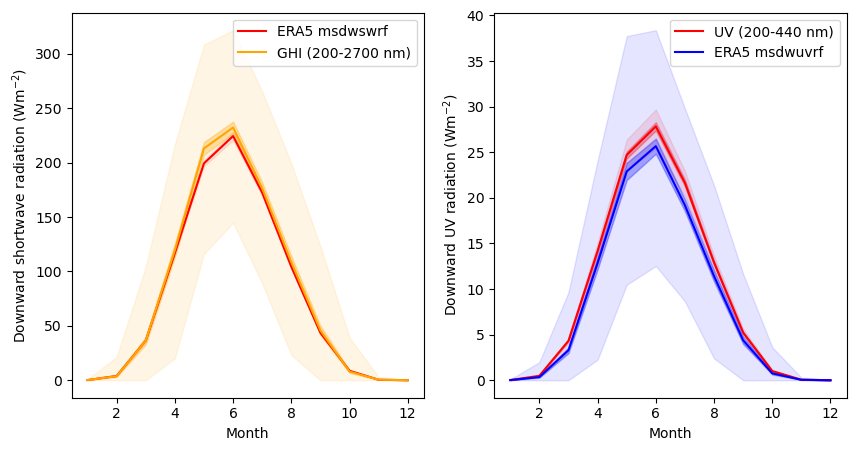

          mean_x      mean_y
time                        
1      21.317125   15.487880
2      48.426968   39.421822
3     101.205185   80.460541
4     155.948608  132.519928
5     190.493805  196.472733
6     193.451187  210.117996
7     162.006622  165.425995
8     130.397064  119.464645
9     103.645370   88.496887
10     62.515121   50.253292
11     27.873276   19.641914
12     14.945148   12.249569
         mean_x     mean_y
time                      
1      2.370807   1.324967
2      5.481630   3.544170
3     11.629097   7.698361
4     18.259867  14.108116
5     22.358452  22.145741
6     23.339472  23.870844
7     20.177925  17.644833
8     16.033424  12.152878
9     12.001566   8.599621
10     6.868389   4.649170
11     3.001259   1.721799
12     1.638229   1.058875
Correlation PAR:           mean_x    mean_y
mean_x  1.000000  0.988448
mean_y  0.988448  1.000000
Correlation UV:           mean_x    mean_y
mean_x  1.000000  0.980999
mean_y  0.980999  1.000000
Created figure Figure

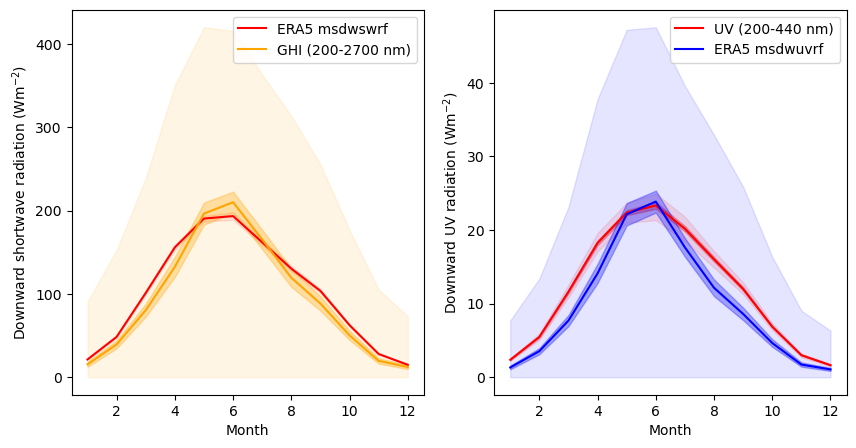

          mean_x      mean_y
time                        
1      -0.000015    0.000000
2       0.103580    0.051503
3      15.574171   14.617200
4     120.682564  123.050964
5     234.736725  218.140640
6     263.501923  237.259033
7     180.651001  180.723709
8     105.700035  110.033623
9      29.328285   31.701977
10      0.839787    0.438707
11     -0.000015    0.000000
12     -0.000015    0.000000
         mean_x     mean_y
time                      
1      0.000002   0.000000
2      0.014189   0.005068
3      1.991190   1.412312
4     15.445668  11.038834
5     31.949526  22.800625
6     36.742176  26.842430
7     26.609528  19.125128
8     15.707200  11.045827
9      4.451400   3.304131
10     0.126610   0.042590
11     0.000002   0.000000
12     0.000002   0.000000
Correlation PAR:           mean_x    mean_y
mean_x  1.000000  0.997826
mean_y  0.997826  1.000000
Correlation UV:           mean_x    mean_y
mean_x  1.000000  0.999876
mean_y  0.999876  1.000000
Created figure Figure

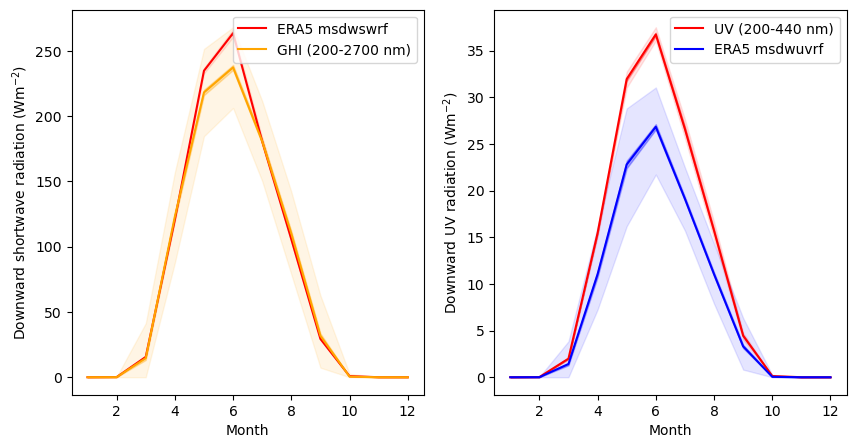

          mean_x      mean_y
time                        
1       1.894997    1.794443
2      15.192710   10.322292
3      71.366753   48.733887
4     159.609634  120.057243
5     228.108459  210.231964
6     243.519394  227.045700
7     182.274048  172.639404
8     114.197845  109.185211
9      62.738968   57.620388
10     19.835533   17.492071
11      2.758978    2.829174
12      0.567739    0.964083
         mean_x     mean_y
time                      
1      0.248783   0.163294
2      1.905422   0.916634
3      8.695581   4.408239
4     20.631411  12.932460
5     31.061232  23.581812
6     32.618122  25.388023
7     24.072834  19.025148
8     14.626946  11.420913
9      7.658567   5.346814
10     2.348470   1.591163
11     0.328259   0.257329
12     0.075631   0.090646
Correlation PAR:           mean_x    mean_y
mean_x  1.000000  0.993798
mean_y  0.993798  1.000000
Correlation UV:          mean_x   mean_y
mean_x  1.00000  0.99388
mean_y  0.99388  1.00000
Created figure Figures/CMIP

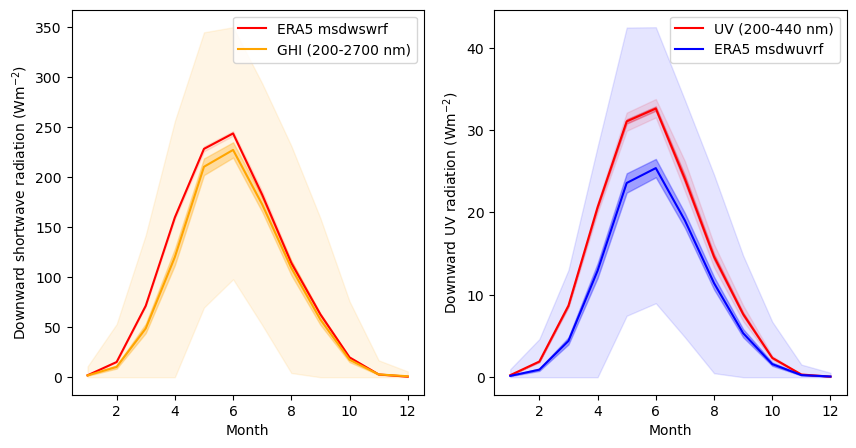

          mean_x      mean_y
time                        
1       0.177621    0.092771
2      10.761583    6.987425
3      67.548332   44.629417
4     161.874817  119.519669
5     239.579575  210.944336
6     264.369965  230.558258
7     207.601959  173.719894
8     124.189941  106.809410
9      62.000343   53.697533
10     16.720301   13.286017
11      0.797846    0.643672
12      0.000166    0.000000
         mean_x     mean_y
time                      
1      0.024062   0.009235
2      1.315850   0.625701
3      7.984345   3.984333
4     20.459167  12.983666
5     32.376583  23.590317
6     34.709656  25.736794
7     26.787233  19.222488
8     15.830746  11.382178
9      7.781470   4.937982
10     2.184591   1.214013
11     0.112195   0.062680
12     0.000031   0.000000
Correlation PAR:           mean_x    mean_y
mean_x  1.000000  0.996674
mean_y  0.996674  1.000000
Correlation UV:           mean_x    mean_y
mean_x  1.000000  0.997168
mean_y  0.997168  1.000000
Created figure Figure

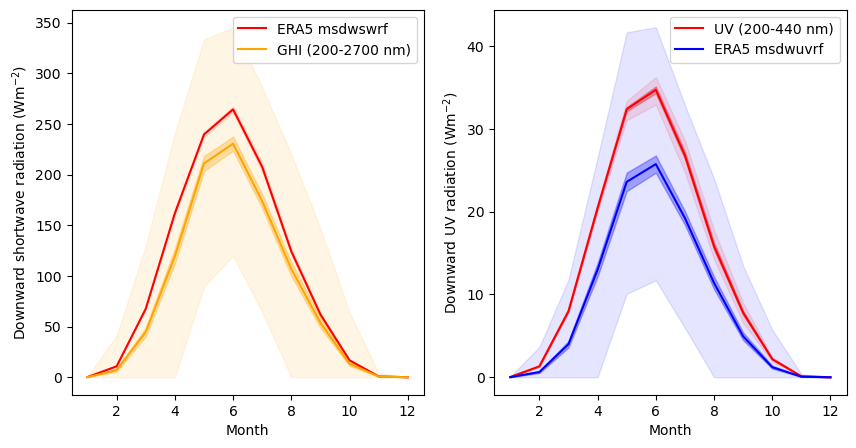

CPU times: user 1min 58s, sys: 26.8 s, total: 2min 25s
Wall time: 2min 29s


In [24]:
%%time
scenarios=["ssp585","ssp245"]
member_range=1
ensemble_ids = ["r{}i{}p{}f{}".format(str(i + 1), str(ii + 1), str(iii + 1), str(iv + 1)) for i in
                           range(member_range)
                           for ii in range(member_range) for iii in range(member_range) for iv in range(member_range)]

period="1979-01-01-2099-12-16"
start_time="1979-01-01"
end_time="2099-12-16"

models=["ACCESS-ESM1-5","CanESM5","UKESM1-0-LL","MPI-ESM1-2-LR"]
era_var_name1="msdwswrf"
era_var_name2="msdwuvrf"
ds_var_name1="ghi"
ds_var_name2="uv_srf"

ds_var_names=["ghi","uv_srf"] #["ghi","osa","par","uvi","uv"]

LMES=['California Current','East Bering Sea','Gulf of Alaska',
              'Northern Bering - Chukchi Seas','West Bering Sea','Sea of Japan',
              'Oyashio Current','Kuroshio Current','East China Sea',
              'South China Sea','Sea of Okhotsk','Yellow Sea',
              'Aleutian Islands']

LMES=['Barents Sea','East Bering Sea','Central Arctic','Northern Bering - Chukchi Seas','Beaufort Sea'] #,'East Bering Sea','Beaufort Sea','Northern Bering - Chukchi Seas',

era_datafile="../oceanography/light/ncfiles/ERA5_global_shortwave_1979_2020.nc"

era = get_mean_era5(era_datafile, start_time, end_time)

#distance = haversine(lon1,lat1,lon2,lat2)

min_lat=50
max_lat=90
min_lon=-180
max_lon=180
era = era.reindex(lat=list(reversed(era.lat)))
era = era.sel(lat=slice(min_lat,max_lat),lon=slice(min_lon,max_lon))

lon1,lat1=np.meshgrid(era.lon.values,era.lat.values)
is_in_ocean = globe.is_ocean(lat1,lon1)
era.coords['mask'] = (('lat', 'lon'), is_in_ocean)
era_ds1=era[era_var_name1]
era_ds2=era[era_var_name2]

for LME in LMES:

    era5_lme1 = get_data_within_LME(era_ds1,era_var_name1,LME,create_map=False)
    era5_lme2 = get_data_within_LME(era_ds2,era_var_name2,LME,create_map=False)

    era1 = era5_lme1.mean({"lat","lon"})
    era2 = era5_lme2.mean({"lat","lon"})

    era_df1=era1.to_dataframe().reset_index()
    era_df2=era2.to_dataframe().reset_index()

    uv_dfs=[]
    sw_dfs=[]

    for scenario in scenarios:
        for model in models:
            for ensemble_id in ensemble_ids:
                fname1 = "../oceanography/light/ncfiles/{}_{}_{}_{}_scenario_osa_{}.nc".format(ds_var_name1, model, ensemble_id,period,scenario)
                fname2="../oceanography/light/ncfiles/{}_{}_{}_{}_scenario_osa_{}.nc".format(ds_var_name2,model, ensemble_id,period,scenario)

                if os.path.exists(fname1) and os.path.exists(fname2):

                    df1 = get_area_averaged_ds(fname1,scenario,model,min_lat,max_lat,min_lon,max_lon,ds_var_name1,LME)
                    df2 = get_area_averaged_ds(fname2,scenario,model,min_lat,max_lat,min_lon,max_lon,ds_var_name2,LME)

                    sw_dfs.append(df1)
                    uv_dfs.append(df2)

    uv_df=pd.concat(uv_dfs)
    sw_df=pd.concat(sw_dfs)

    # Shortwave radiation as function of month (mean + 0.95 CI)
    era_df_mean1 = calculate_stats(era_df1, era_var_name1)
    sw_mean = calculate_stats(sw_df, ds_var_name1)

    # UV (200-440nm) radiation as function of month (mean + 0.95 CI)
    era_df_mean2 = calculate_stats(era_df2, era_var_name2)
    uv_mean = calculate_stats(uv_df, ds_var_name2)

    fig1=plt.figure(figsize=(10,5))
    axes1 = fig1.add_subplot(121)
    axes2 = fig1.add_subplot(122)

    axes1.plot(era_df_mean1.index, era_df_mean1["mean"], alpha=1.0, color="red", label="ERA5 {}".format(era_var_name1))
    axes1.fill_between(era_df_mean1.index, era_df_mean1["ci95_lo"], era_df_mean1["ci95_hi"], alpha=0.1, color="red")

    axes1.plot(sw_mean.index, sw_mean["mean"], alpha=1.0, color="orange", label="GHI (200-2700 nm)")
    axes1.fill_between(sw_mean.index, sw_mean["q25"], sw_mean["q75"], alpha=0.1, color="orange")
    axes1.fill_between(sw_mean.index, sw_mean["ci95_lo"], sw_mean["ci95_hi"], alpha=0.3, color="orange")
    axes1.legend(loc="upper right")

    axes2.plot(era_df_mean2.index, era_df_mean2["mean"], alpha=1.0, color="red", label="UV (200-440 nm)")
    axes2.fill_between(era_df_mean2.index, era_df_mean2["q25"], era_df_mean2["q75"], alpha=0.1, color="red")
    axes2.fill_between(era_df_mean2.index, era_df_mean2["ci95_lo"], era_df_mean2["ci95_hi"], alpha=0.3, color="red")

    axes2.plot(uv_mean.index, uv_mean["mean"], alpha=1.0, color="blue", label="ERA5 {}".format(era_var_name2))
    axes2.fill_between(uv_mean.index, uv_mean["q25"], uv_mean["q75"], alpha=0.1, color="blue")
    axes2.fill_between(uv_mean.index, uv_mean["ci95_lo"], uv_mean["ci95_hi"], alpha=0.3, color="blue")

    axes1.set_ylabel("Downward shortwave radiation (Wm$^{-2}$)")
    axes2.set_ylabel("Downward UV radiation (Wm$^{-2}$)")
    axes1.set_xlabel("Month")
    axes2.set_xlabel("Month")
    axes2.legend(loc="upper right")

    merged = pd.merge_asof(era_df_mean1["mean"], sw_mean["mean"], left_index=True, right_index=True, direction='nearest')
    print(merged)
    merged_uv = pd.merge_asof(era_df_mean2["mean"], uv_mean["mean"], left_index=True, right_index=True, direction='nearest')
    print(merged_uv)

    print("Correlation PAR: {}".format(merged.corr()))
    print("Correlation UV: {}".format(merged_uv.corr()))

    plotfile="Figures/CMIP6_lightpaper_sw+uv_compared_ERA_{}.png".format(LME)
    print("Created figure {}".format(plotfile))
    plt.savefig(plotfile, dpi=300,
                    bbox_inches = 'tight')
    plt.show()

    # For each variable in the list create a time-series plot
    timeseries=False
    if timeseries:
        for var_name in ds_var_names:
            for model in models:
                for ensemble_id in ensemble_ids:
                    fname = "../oceanography/light/ncfiles/{}_{}_{}_{}_scenario_osa_{}.nc".format(ds_var_name1, model,
                                                                                                  ensemble_id,period,
                                                                                                  scenario)

                    if os.path.exists(fname):
                        df = get_area_averaged_ds(fname,scenario,model,min_lat,max_lat,min_lon,max_lon,var_name,LME)
                      #  df = uv_df
                        df_a = df.resample("A", on="time").mean()
                        fig2, axes2 = plt.subplots(1, 1)
                        sns.lineplot(ax=axes2, data=df, x=df.time, y=var_name,
                                     ci=95, alpha=0.65,
                                     legend="auto", label="CMIP6 {} monthly".format(var_name))
                        sns.lineplot(ax=axes2, data=df_a, x=df_a.index, y=var_name,
                                     ci=95, alpha=0.95,
                                     legend="auto", label="CMIP6 {} annual".format(var_name))

                        plt.show()